# t-SNE embeddings of behavior for different user types, and human vs AI behavior

This notebook plots t-SNE embeddings for behavior across different recruitment channels, and human and AI behavior in competitive and cooperative 2-player Space Invaders. It also shows action distributions for a few particular clusters of behavior. You first need to calculate action distributions using batch_create_metadata.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import math
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.manifold import TSNE
sns.set()

from crowdplay_datasets.dataset import get_trajectory_by_id, get_engine_and_session, EpisodeModel, UserModel, EnvironmentModel, EnvironmentKeywordDataModel, EpisodeKeywordDataModel
_, session = get_engine_and_session("crowdplay_atari-v0")

P1 = 'game_0>player_0'
P2 = 'game_0>player_1'

In [2]:
# All the episodes, users and environments, for further filtering in Python
all_episodes = session.query(EpisodeModel).all()

In [3]:
def one_hot(x, length):
    o = [0 for _ in range(length)]
    o[x] = 1
    return o

def data_for_episode(episode, player):
    actions = []
    trajectory = get_trajectory_by_id(episode.episode_id)
    for i in range(len(trajectory)):
        actions.append(one_hot(trajectory[i]["action"][player]['game'], 16))
    actions_frequency = {}
    for a in range(len(actions[0])):
        actions_frequency[f"action_{a}"] = sum([actions[i][a] for i in range(len(trajectory))])/len(trajectory)
    data = {}
    data.update(actions_frequency)
    data['episode_length'] = len(trajectory)
    data['score'] = episode.keyword_data[player]['Score']
    return data

In [3]:
k=200

import random

episodes = [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_ai_competitive_mturk', 'space_invaders_ai_cooperative_mturk']]
# episodes = random.sample(episodes, k)


/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


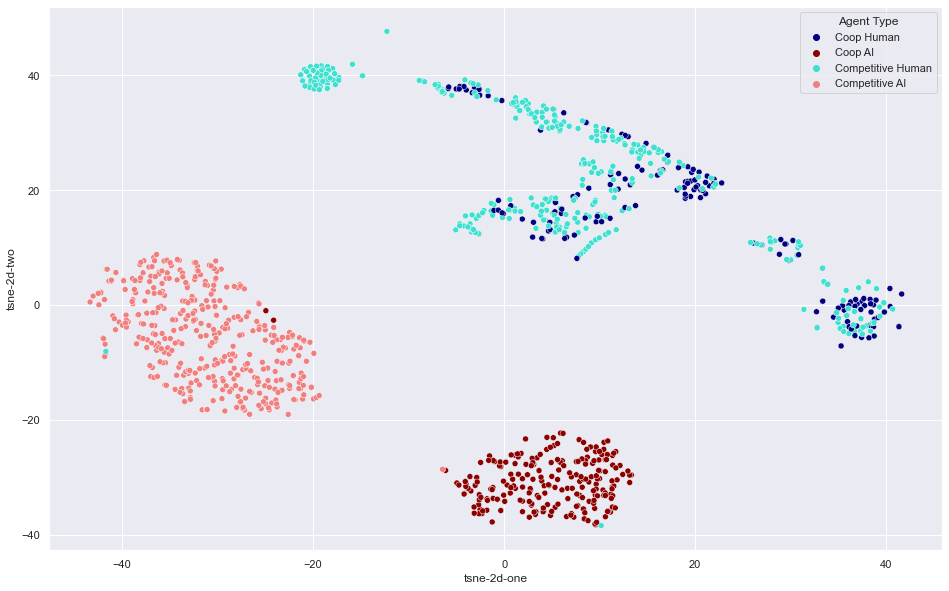

In [4]:
P1 = 'game_0>player_0'
P2 = 'game_0>player_1'

data = []
for ep in episodes:
    d = {'task': 1 if ep.environment.task_id == 'space_invaders_ai_competitive_mturk' else 0, 'agent': 0}
    # d.update(data_for_episode(ep, P1))
    d.update(ep.keyword_data[P1]['action_dist_data'])
    data.append(d)
    d = {'task': 1 if ep.environment.task_id == 'space_invaders_ai_competitive_mturk' else 0, 'agent': 1}
    # d.update(data_for_episode(ep, P2))
    d.update(ep.keyword_data[P2]['action_dist_data'])
    data.append(d)

df = pandas.DataFrame(data)
df = df.drop('episode_length', 1)
df = df.drop('score', 1)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(init='pca')
df_subset = df.drop('agent', 1).drop('task', 1)
tsne_results = tsne.fit_transform(df_subset)

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
df_fig['agent_task'] = df.apply(lambda row: f"{int(row['agent'])}_{int(row['task'])}", axis=1)
agenttask_to_string = {
    '0_0': 'Coop Human',
    '0_1': 'Competitive Human',
    '1_0': 'Coop AI',
    '1_1': 'Competitive AI',
    }
df_fig['Agent Type'] = df_fig.apply(lambda row: agenttask_to_string[row['agent_task']], axis=1)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette={'Competitive AI': 'lightcoral',
        'Coop AI': 'darkred',
        'Competitive Human': 'turquoise',
        'Coop Human': 'navy'},
    # style="agent",
    hue="Agent Type",
    data=df_fig,
)
plt.savefig('tsne_multiagent.pdf',bbox_inches='tight')

/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/matthias/.pyenv/versions/3.7.7/envs/atari-crowdsourcing-test/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


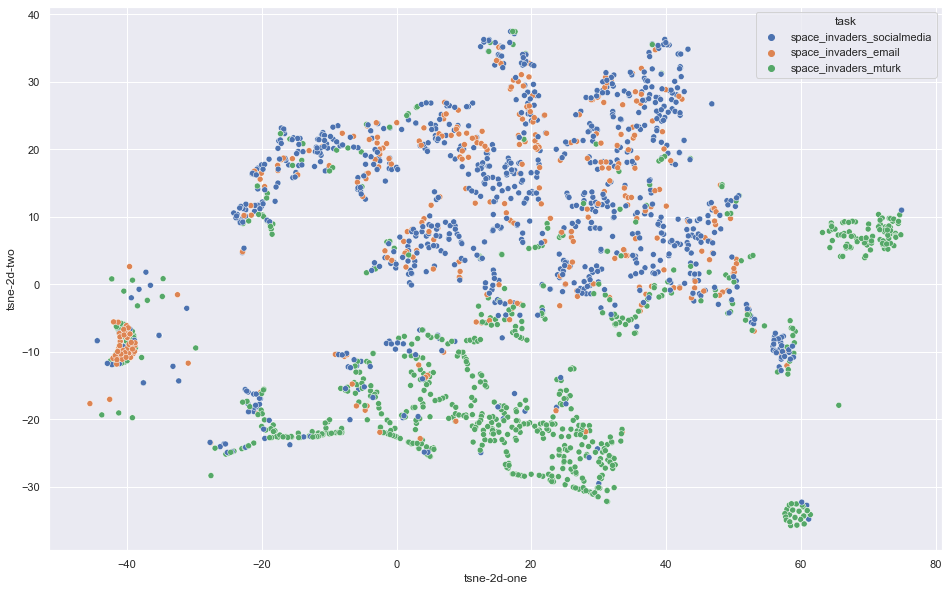

In [5]:
P1 = 'game_0>player_0'
P2 = 'game_0>player_1'
import math
data = []
for ep in [ep for ep in all_episodes if ep.environment.task_id in ['space_invaders_mturk', 'space_invaders_socialmedia', 'space_invaders_email']]:
    if 'action_dist_data' not in ep.keyword_data[P1]:
        print(f"action dist not found for episode {ep.episode_id}")
    else:
        d = {'task': ep.environment.task_id, 'length': ep.keyword_data[P1]['Time played'].total_seconds(), 'score': (ep.keyword_data[P1]['Score'])}
        d.update(ep.keyword_data[P1]['action_dist_data'])
        data.append(d)

df = pandas.DataFrame(data)
df = df.fillna(0)

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne = TSNE(init='pca')
# tsne = TSNE()
df_subset = df.drop('task', 1).drop('score', 1).drop('length',1).drop('episode_length',1)
tsne_results = tsne.fit_transform(df_subset)

df_fig = df.copy()
df_fig['tsne-2d-one'] = tsne_results[:,0]
df_fig['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="agent",
    hue="task",
    data=df_fig,
)
plt.savefig('tsne_usertypes.pdf',bbox_inches='tight')

In [25]:
df_orangecluster = df_fig.query('`tsne-2d-one` < -30').sort_values('score', 0)
df_orangecluster

,task,length,score,action_0,action_1,action_2,action_3,action_4,action_5,action_6,...,action_11,action_12,action_13,action_14,action_15,episode_length,action_16,action_17,tsne-2d-one,tsne-2d-two
15,space_invaders_socialmedia,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,197,0.0,0.0,-44.421230,-8.356245
1763,space_invaders_socialmedia,2.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,171,0.0,0.0,-36.528633,-0.153604
1752,space_invaders_socialmedia,46.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2767,0.0,0.0,-41.188099,-7.191380
1749,space_invaders_socialmedia,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,0.0,0.0,-40.533329,-9.237642
1736,space_invaders_socialmedia,2.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,178,0.0,0.0,-41.146725,-11.759342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,space_invaders_email,46.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2767,0.0,0.0,-44.421230,-8.356245
1382,space_invaders_email,46.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2767,0.0,0.0,-44.421230,-8.356245
1398,space_invaders_email,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,58,0.0,0.0,-44.421230,-8.356245
1326,space_invaders_email,37.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2255,0.0,0.0,-44.421230,-8.356245


In [17]:
df_greencluster = df_fig.query('`tsne-2d-one` > 40').query('`tsne-2d-two` < -30')
df_greencluster

,task,length,score,action_0,action_1,action_2,action_3,action_4,action_5,action_6,...,action_11,action_12,action_13,action_14,action_15,episode_length,action_16,action_17,tsne-2d-one,tsne-2d-two
4,space_invaders_socialmedia,4.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,270,0.0,0.0,61.166885,-34.761860
27,space_invaders_socialmedia,24.0,105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1495,0.0,0.0,57.934704,-33.312786
64,space_invaders_socialmedia,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,140,0.0,0.0,58.792969,-33.422428
270,space_invaders_socialmedia,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,142,0.0,0.0,60.883976,-32.720142
478,space_invaders_socialmedia,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15,0.0,0.0,61.166885,-34.761860
960,space_invaders_mturk,48.0,285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2901,0.0,0.0,60.334408,-32.936638
1765,space_invaders_socialmedia,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,130,0.0,0.0,58.327621,-34.126030
2075,space_invaders_mturk,48.0,285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2901,0.0,0.0,59.418972,-35.655621
2076,space_invaders_mturk,48.0,285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2901,0.0,0.0,59.975021,-34.809166
2078,space_invaders_mturk,48.0,285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2901,0.0,0.0,61.414070,-34.088924


In [27]:
df_greencluster2 = df_fig.query('`tsne-2d-one` > 60').query('`tsne-2d-two` > 0')
df_greencluster2

,task,length,score,action_0,action_1,action_2,action_3,action_4,action_5,action_6,...,action_11,action_12,action_13,action_14,action_15,episode_length,action_16,action_17,tsne-2d-one,tsne-2d-two
401,space_invaders_socialmedia,2.0,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,141,0.0,0.0,74.950302,10.973587
1135,space_invaders_mturk,56.0,335,0.212955,0.062703,0.005915,0.000296,0.372967,0.345164,0.0,...,0.0,0.0,0.0,0.0,0.0,3381,0.0,0.0,68.289017,6.720814
1137,space_invaders_mturk,37.0,85,0.251218,0.011520,0.013735,0.000000,0.393000,0.330527,0.0,...,0.0,0.0,0.0,0.0,0.0,2257,0.0,0.0,67.784225,7.138882
1139,space_invaders_mturk,31.0,110,0.402407,0.049712,0.053375,0.063841,0.289377,0.141287,0.0,...,0.0,0.0,0.0,0.0,0.0,1911,0.0,0.0,64.218620,7.875023
1140,space_invaders_mturk,40.0,295,0.082610,0.020240,0.002065,0.000000,0.602230,0.292854,0.0,...,0.0,0.0,0.0,0.0,0.0,2421,0.0,0.0,73.641876,9.337200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,space_invaders_mturk,76.0,675,0.042022,0.206610,0.001532,0.000000,0.405559,0.344277,0.0,...,0.0,0.0,0.0,0.0,0.0,4569,0.0,0.0,69.635345,4.203051
2154,space_invaders_mturk,37.0,210,0.000444,0.016866,0.000000,0.000000,0.583666,0.399024,0.0,...,0.0,0.0,0.0,0.0,0.0,2253,0.0,0.0,74.849297,7.328197
2156,space_invaders_mturk,39.0,260,0.312208,0.195661,0.051042,0.040408,0.326244,0.074436,0.0,...,0.0,0.0,0.0,0.0,0.0,2351,0.0,0.0,64.310570,5.427857
2318,space_invaders_mturk,47.0,155,0.368682,0.037469,0.010604,0.039943,0.542948,0.000353,0.0,...,0.0,0.0,0.0,0.0,0.0,2829,0.0,0.0,64.675514,6.467683
